# Import modules

In [1]:
#import general modules
import numpy as np
import io, sys, time, math, os.path, unittest, sys
import matplotlib.pyplot as plt
import pandas as pd

# Load files

In [2]:
#Todo: use sys commands to dynamically find in github folder
github_folder='/Users/mrubashkin/greenspace/'
file_location=github_folder+'raw_data/Dept_Interior_Data/'

file_name='NRRS_reservations_byVisitorOriginZip_AllYears.csv'
zip_origin_df=pd.read_csv(file_location+file_name)

file_name='NRRS_reservations_byFacilityName_AllYears.csv'
by_campground_df=pd.read_csv(file_location+file_name)

file_name='PPL_reservationdata.csv' #2.2gb --> very large
reservation_df=by_campground_df=pd.read_csv(file_location+file_name)


In [3]:
#load models (distance to park)
github_folder='/Users/mrubashkin/greenspace/'
file_location=github_folder+'raw_data/'
file_name='ESRI_ZipCodes_wDistance2nearestFacility_km.txt'
distance_to_park_df=pd.read_csv(file_location+file_name)
#distance_to_park_df[['D2NF_km','ZIP_CODE']]

In [4]:
#Census Data
file_location=github_folder+'raw_data/'

file_name='aggregate_income.csv'
income_df=pd.read_csv(file_location+file_name)

file_name='2010CensusPopulationData.csv'
racial_info_df=pd.read_csv(file_location+file_name)

#distance from zip code to the park
file_name='ESRI_ZipCodes_wDistance2nearestFacility_km.txt'
distance_to_park_df=pd.read_csv(file_location+file_name)
distance_to_park_df[['D2NF_km','ZIP_CODE']]

#health/disabilty
file_name='disability.csv'
disability_df=pd.read_csv(file_location+file_name)
'''
TODO: Rename these columns, the one 'total is a BAD idea
'''

file_name='education.csv'
education_df=pd.read_csv(file_location+file_name)
education_df.rename(columns={'zip code tabulation area': 'zip_code_tabulation_area'},inplace=True)
education_df.rename(columns={'B06009_001E': 'Total_reported_education_per_zip'},inplace=True)
education_df.rename(columns={'B06009_002E': 'Less_than_high_school_graduate'},inplace=True)
education_df.rename(columns={'B06009_003E': 'High_school_graduate'},inplace=True)
education_df.rename(columns={'B06009_004E': 'Some_college_or_associates_degree'},inplace=True)
education_df.rename(columns={'B06009_005E': 'Bachelor_degree'},inplace=True)
education_df.rename(columns={'B06009_006E': 'Graduate_or_professional_degree'},inplace=True)
education_df=education_df[['zip_code_tabulation_area','Less_than_high_school_graduate','High_school_graduate'
                ,'Some_college_or_associates_degree','Bachelor_degree','Graduate_or_professional_degree'
                ,'Total_reported_education_per_zip']]
#education_df

In [5]:
#drop the duplicate columns and use to merge
temp=reservation_df.drop_duplicates(subset = ' CustZip')
temp=temp[[' CustState',' CustCountry',' CustZip']]
temp[' CustZip']=pd.to_numeric(temp[' CustZip'], errors='coerce')

# Join dataframes

In [6]:
#join the dataframes
aggregate_df= pd.merge(zip_origin_df, racial_info_df, left_on = 'visitor_zip', right_on = 'Zip')
aggregate_df= pd.merge(aggregate_df,income_df,left_on='visitor_zip',right_on='zip code tabulation area')
#move the line below to higher up
aggregate_df.rename(columns={'Annual Aggregate Family Income': 'Annual_Aggregate_Family_Income'},inplace=True)
aggregate_df= pd.merge(aggregate_df,temp,left_on = 'visitor_zip', right_on = ' CustZip')
aggregate_df= pd.merge(aggregate_df,education_df,left_on='visitor_zip',right_on='zip_code_tabulation_area')
aggregate_df= pd.merge(aggregate_df,distance_to_park_df,left_on='visitor_zip',right_on='ZIP_CODE')
aggregate_df= pd.merge(aggregate_df,disability_df, left_on='visitor_zip',right_on='zipcode')
#aggregate_df

In [7]:
print aggregate_df.columns[0:50]
print aggregate_df.columns[50:-1]

Index([u'visitor_zip', u'visitorzip_lat', u'visitorzip_lon', u'qpartysize25',
       u'qpartysize50', u'qpartysize75', u'qleadt25', u'qleadt50', u'qleadt75',
       u'qdur25', u'qdur50', u'qdur75', u'qdist25', u'qdist50', u'qdist75',
       u'res_count', u'sum_dur', u'sum_persnight', u'Zip', u'Population',
       u'PopulationMale', u'PopulationFemale', u'MedianAge', u'MedianAgeMale',
       u'MedianAgeFemale', u'PopulationRaceWhite', u'PopulationRaceBlack',
       u'PopulationAmerindian', u'PopulationRaceAsian',
       u'PopulationRacePacific', u'PopulationRaceOther',
       u'PopulationRaceMulti', u'PopulationRaceLatino', u'Households',
       u'HusbandWifeHouseholds', u'SingleFatherHousehold',
       u'SingleMotherHousehold', u'NonFamilyHouseholds', u'HouseHolder15to24',
       u'HouseHolder25to34', u'HouseHolder35to44', u'HouseHolder45to54',
       u'HouseHolder55to59', u'HouseHolder60to64', u'HouseHolder65to74',
       u'HouseHolder75to84', u'HouseHolder85over', u'HouseholdsWith60P

In [8]:
#rename columns without spaces
aggregate_df.rename(columns={' CustZip': 'CustZip'},inplace=True)
aggregate_df.rename(columns={' CustState': 'CustState'},inplace=True)
aggregate_df.rename(columns={' CustCountry': 'Custcountry'},inplace=True)
aggregate_df.iloc[0]['Custcountry']

'USA'

# Create new columns

In [9]:
#get the utilization_factors into the dataframe
aggregate_df['util_unique'] = pd.Series(
    (aggregate_df.sum_dur / aggregate_df.Population))
aggregate_df['util_days']= pd.Series(
    (aggregate_df.sum_persnight  / aggregate_df.Population))

In [10]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['sum_dur']\
    /float(aggregate_df.iloc[[0]]['Population'])),\
     float(aggregate_df.iloc[[0]]['util_unique']))

This 0.000754 should equal that 0.000754


In [11]:
#get the male/female breakdowns per visit per zip code
#using unique visits for the rest of these breakdowns!! (i.e. sum_dur)
aggregate_df['visits_female'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))
aggregate_df['visits_male'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))

In [12]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationFemale']\
    /float(aggregate_df.iloc[[0]]['Population']))\
    *float(aggregate_df.iloc[[0]]['sum_dur']),\
     float(aggregate_df.iloc[[0]]['visits_female']))

This 7.156058 should equal that 7.156058


In [13]:
#get the race breakdown per visit per zip code
aggregate_df['visits_RaceWhite'] = pd.Series(
    (aggregate_df.PopulationRaceWhite * aggregate_df.sum_dur))
aggregate_df['visits_RaceBlack'] = pd.Series(
    (aggregate_df.PopulationRaceBlack * aggregate_df.sum_dur))
aggregate_df['visits_Amerindian'] = pd.Series(
    (aggregate_df.PopulationAmerindian * aggregate_df.sum_dur))
aggregate_df['visits_RacePacific'] = pd.Series(
    (aggregate_df.PopulationRacePacific * aggregate_df.sum_dur))
aggregate_df['visits_RaceLatino'] = pd.Series(
    (aggregate_df.PopulationRaceLatino * aggregate_df.sum_dur))
aggregate_df['visits_RaceMulti'] = pd.Series(
    (aggregate_df.PopulationRaceMulti * aggregate_df.sum_dur))
aggregate_df['visits_RaceOther'] = pd.Series(
    (aggregate_df.PopulationRaceOther * aggregate_df.sum_dur))

In [14]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationRaceWhite']\
    *float(aggregate_df.iloc[[0]]['sum_dur'])),\
     float(aggregate_df.iloc[[0]]['visits_RaceWhite']))

This 0.060312 should equal that 0.060312


In [15]:
#scale the annual family aggregate income (which is per zip code)
#to individual families
aggregate_df['per_family_annual_income'] = pd.Series(
    (aggregate_df.Annual_Aggregate_Family_Income / aggregate_df.Households))

In [16]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['Annual_Aggregate_Family_Income']\
    /float(aggregate_df.iloc[[0]]['Households'])),\
     float(aggregate_df.iloc[[0]]['per_family_annual_income']))


This 16366.160920 should equal that 16366.160920


In [17]:
#get percent of people who are high school educated
aggregate_df['non_hs_educated'] = pd.Series(
    (aggregate_df.Less_than_high_school_graduate / aggregate_df.Total_reported_education_per_zip))

In [18]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[-1]]['Less_than_high_school_graduate']\
    /float(aggregate_df.iloc[[-1]]['Total_reported_education_per_zip'])),\
     float(aggregate_df.iloc[[-1]]['non_hs_educated']))

This 0.109489 should equal that 0.109489


In [19]:
#get percent of people who are high school educated
aggregate_df['disabled_percent'] = pd.Series(
    (aggregate_df.disabled / aggregate_df.total))

In [20]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[-1]]['disabled']\
    /float(aggregate_df.iloc[[-1]]['total'])),\
     float(aggregate_df.iloc[[-1]]['disabled_percent']))

This 0.257353 should equal that 0.257353


# Trim data

In [21]:
#create the data to send to Cartos DB and use for the graphing
regression_df=aggregate_df[[
        'CustZip',
        'CustState',
        'per_family_annual_income',
        'non_hs_educated',
        'PopulationRaceWhite',
        'D2NF_km',
        'util_days',
        'disabled_percent'
        ]]
#remove inf and NaN
regression_df=regression_df.replace([np.inf, -np.inf], np.nan).dropna()
#rename the distance column
regression_df.rename(columns={'D2NF_km': 'Dist_to_park'},inplace=True)
#save the max values    
income_max=regression_df['per_family_annual_income'].max()
dist_to_park_max=regression_df['Dist_to_park'].max()
#print random entry
regression_df.iloc[1000]

CustZip                          4460
CustState                          ME
per_family_annual_income      38083.6
non_hs_educated              0.122984
PopulationRaceWhite          0.987315
Dist_to_park                  140.192
util_days                   0.0190275
disabled_percent             0.212673
Name: 1092, dtype: object

# Save the trimmed datframe to database

In [22]:
#save the dataframe to a csv
file_location=github_folder + 'processed_data/'
file_name='test7.csv'
regression_df.to_csv(file_location+file_name, sep=',')

## Scale the columns to 0 to 1 for machine learning

In [23]:
#scale columns to 0-->1
regression_df[['per_family_annual_income']]=\
regression_df[['per_family_annual_income']].divide(\
    regression_df['per_family_annual_income'].max())
regression_df[['Dist_to_park']]=\
regression_df[['Dist_to_park']].divide(\
    regression_df['Dist_to_park'].max())

# Linear Regression

In [24]:
import statsmodels.api as sm

#remove potential ouliers
min_visitation_value=.01
regression_df_editted = regression_df[regression_df.util_days > min_visitation_value]

y=regression_df_editted['util_days'].tolist()

x=[regression_df_editted['per_family_annual_income'].tolist(),
   regression_df_editted['non_hs_educated'].tolist(),
   regression_df_editted['PopulationRaceWhite'].tolist(),
   regression_df_editted['Dist_to_park'].tolist(),
   regression_df_editted['disabled_percent'].tolist(),
   ]

#calculate the y-intercept guess
y_intercept_guess=regression_df_editted['util_days'].median()
y_intercept_guess=0

def reg_m(y, x, y_intercept_guess):
    y_intercepts = np.empty(len(x[0]))
    y_intercepts.fill(y_intercept_guess)
    X = sm.add_constant(np.column_stack((x[0], y_intercepts)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

reg_m(y,x,y_intercept_guess)
print reg_m(y, x,y_intercept_guess).summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     1925.
Date:                Sat, 23 Apr 2016   Prob (F-statistic):               0.00
Time:                        23:05:25   Log-Likelihood:                -57051.
No. Observations:               29698   AIC:                         1.141e+05
Df Residuals:                   29693   BIC:                         1.142e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.8051      0.156     11.539      0.0

# Decision Tree Testing

data /n [[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]
 [ 5.4  3.9  1.7  0.4]
 [ 4.6  3.4  1.4  0.3]
 [ 5.   3.4  1.5  0.2]
 [ 4.4  2.9  1.4  0.2]
 [ 4.9  3.1  1.5  0.1]
 [ 5.4  3.7  1.5  0.2]
 [ 4.8  3.4  1.6  0.2]
 [ 4.8  3.   1.4  0.1]
 [ 4.3  3.   1.1  0.1]
 [ 5.8  4.   1.2  0.2]
 [ 5.7  4.4  1.5  0.4]
 [ 5.4  3.9  1.3  0.4]
 [ 5.1  3.5  1.4  0.3]
 [ 5.7  3.8  1.7  0.3]
 [ 5.1  3.8  1.5  0.3]
 [ 5.4  3.4  1.7  0.2]
 [ 5.1  3.7  1.5  0.4]
 [ 4.6  3.6  1.   0.2]
 [ 5.1  3.3  1.7  0.5]
 [ 4.8  3.4  1.9  0.2]
 [ 5.   3.   1.6  0.2]
 [ 5.   3.4  1.6  0.4]
 [ 5.2  3.5  1.5  0.2]
 [ 5.2  3.4  1.4  0.2]
 [ 4.7  3.2  1.6  0.2]
 [ 4.8  3.1  1.6  0.2]
 [ 5.4  3.4  1.5  0.4]
 [ 5.2  4.1  1.5  0.1]
 [ 5.5  4.2  1.4  0.2]
 [ 4.9  3.1  1.5  0.1]
 [ 5.   3.2  1.2  0.2]
 [ 5.5  3.5  1.3  0.2]
 [ 4.9  3.1  1.5  0.1]
 [ 4.4  3.   1.3  0.2]
 [ 5.1  3.4  1.5  0.2]
 [ 5.   3.5  1.3  0.3]
 [ 4.5  2.3  1.3  0.3]
 [ 4.4  3.2  1.3  0.2]
 [ 

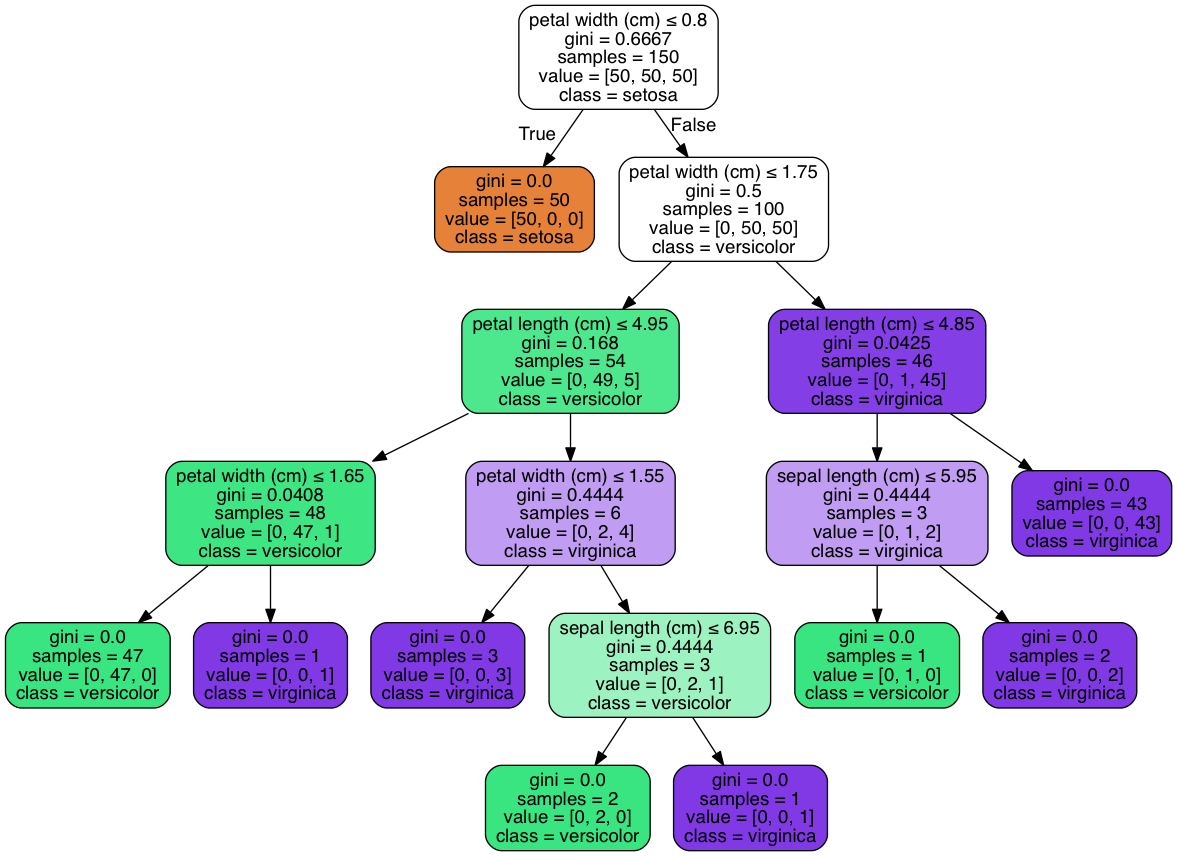

In [31]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)
print 'data /n', iris.data
print 'target /n', iris.target

from sklearn.externals.six import StringIO
with open("iris.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)
    
import os
os.unlink('iris.dot')

from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("iris.pdf") 

from IPython.display import Image  
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  


TODO
make a unittest to make sure this is joined correctly



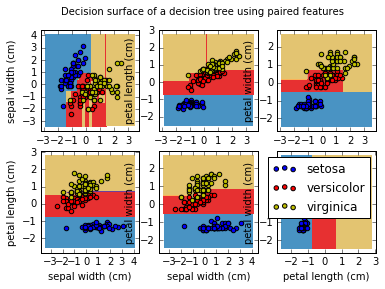

In [32]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

# Load data
iris = load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(13)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Standardize
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)

    plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()

# Plot correlations

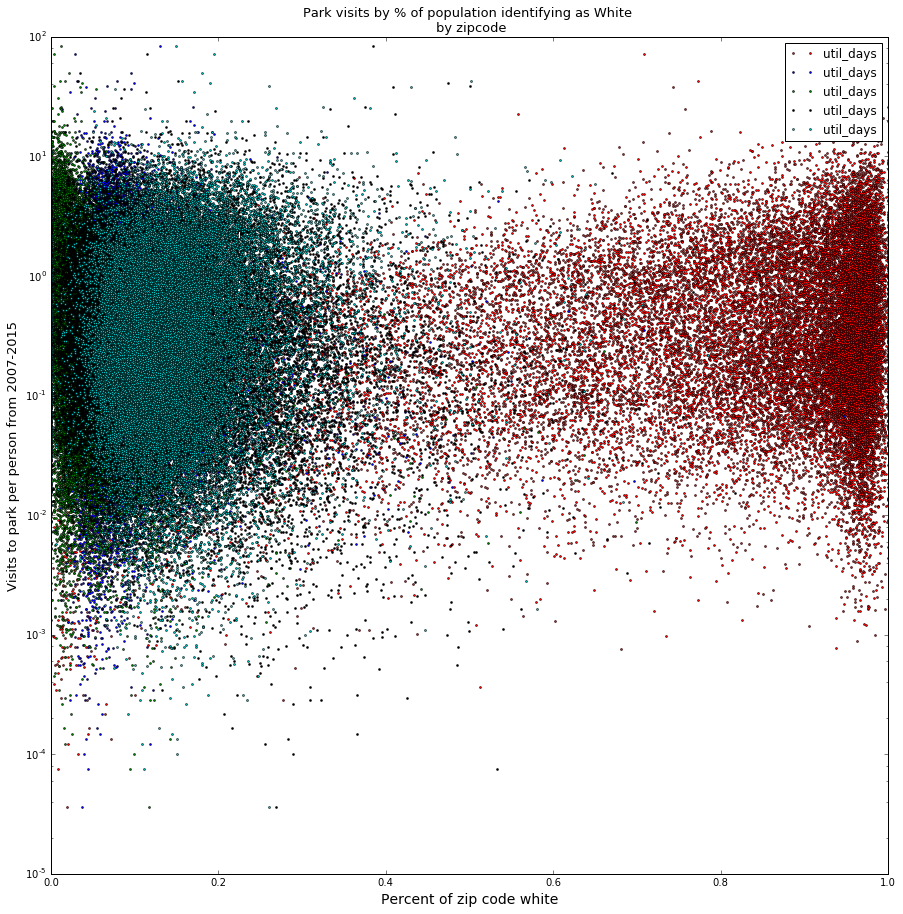

In [26]:
%matplotlib inline
plt.figure(figsize=(15,15))
plt.semilogy(regression_df['PopulationRaceWhite'],regression_df['util_days'],'ro',\
             regression_df['per_family_annual_income'],regression_df['util_days'],'bo',\
             regression_df['Dist_to_park'],regression_df['util_days'],'go',\
             regression_df['non_hs_educated'],regression_df['util_days'],'ko',\
             regression_df['disabled_percent'],regression_df['util_days'],'co',markersize = 2
             )

plt.xlabel('Percent of zip code white',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by % of population identifying as White \n by zipcode', size=13)
plt.legend(loc='upper right',prop={'size':12})


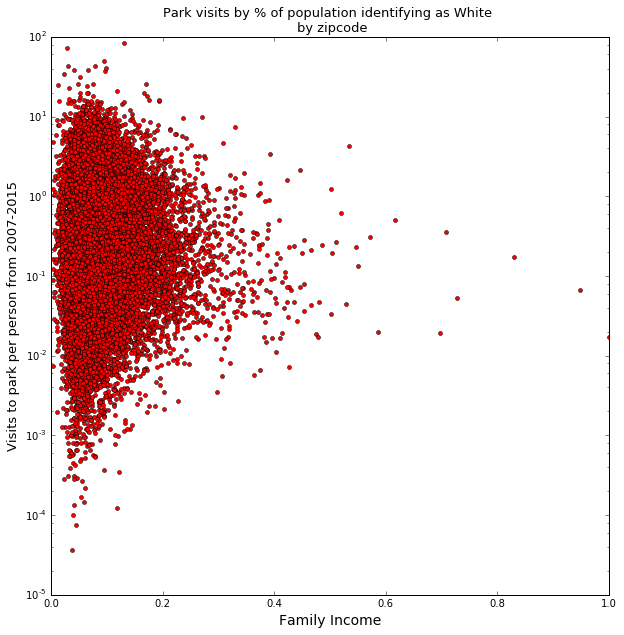

In [27]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['per_family_annual_income'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Family Income',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by % of population identifying as White \n by zipcode', size=13)

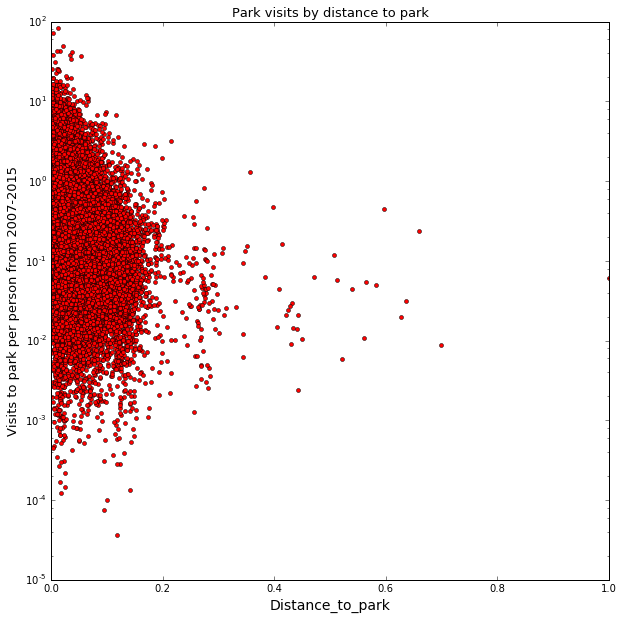

In [28]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['Dist_to_park'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Distance_to_park',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by distance to park', size=13)

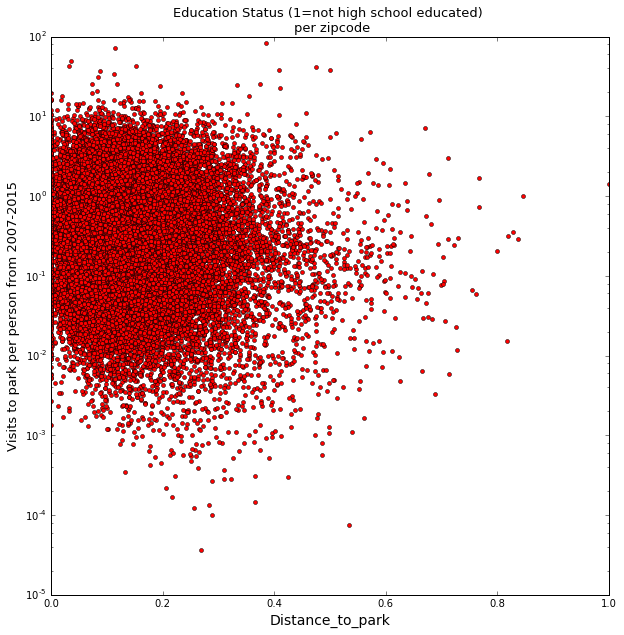

In [29]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['non_hs_educated'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Distance_to_park',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Education Status (1=not high school educated) \n per zipcode', size=13)